In [2]:
import keras
import keras.layers as layers
import keras.activations as activations
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [201]:
X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('Y_train.npy')

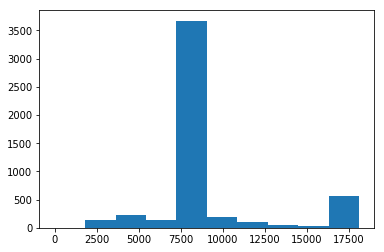

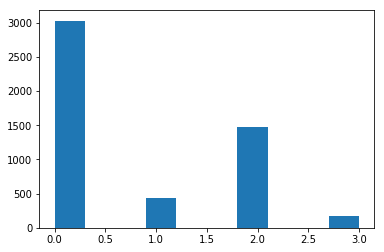

In [203]:
plt.hist(np.isnan(X_train).argmax(axis=1)) # Sequence length distribution
plt.figure()
plt.hist(y_train[:, 1]); # Class distribution

In [204]:
# Add channel dimension
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Convert to one-hot
y_train = keras.utils.to_categorical(y_train[:, 1])

# Create validations set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [272]:
def feed(X, y, training=True, shorten=False, batch_size=128):
    seqlens = np.isnan(X[:,:,0]).argmax(axis=1)
    seqlens[seqlens == 0] = X.shape[1]
    
    # Loop over epochs
    while True:
        idx = np.arange(X.shape[0])
        
        if training:
            np.random.shuffle(idx)
                
        # Loop over batches
        for k in range(0, X.shape[0], batch_size):        
            X_batch, y_batch = [], []

            # Loop over examples
            for j in range(k, min(X.shape[0], k+batch_size)):
                i = idx[j]
                example = np.copy(X[i])
                
                # Randomly set runs to zero
                if training:
                    for _ in range(int(seqlens[i] / X.shape[1] * 50)):
                        blen = np.random.randint(50, 150)
                        pos = np.random.randint(seqlens[i]-blen)
                        example[pos:pos+blen] = 0

                if training and not shorten:
                    # Repeat sequence to fill padding
                    example = np.tile(example[:seqlens[i]], [int(np.ceil(X.shape[1] / seqlens[i])),1])
                    example = example[:X.shape[1]]
                elif training and shorten:
                    # Choose random window to shorten sequence
                    offset = np.random.randint(seqlens[i] - seqlens.min() + 1)
                    example = example[offset:offset+seqlens.min()]

                X_batch.append(example)
                
                if y is not None:
                    y_batch.append(y[i])
                
            if y is not None:
                yield np.array(X_batch), np.array(y_batch)
            else:
                yield np.array(X_batch)

(128, 2606, 1)


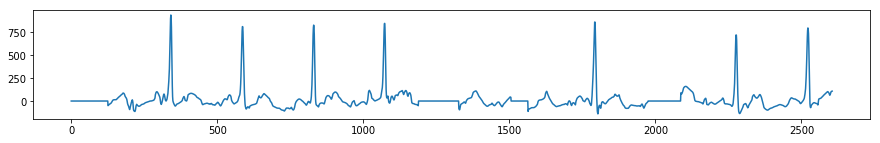

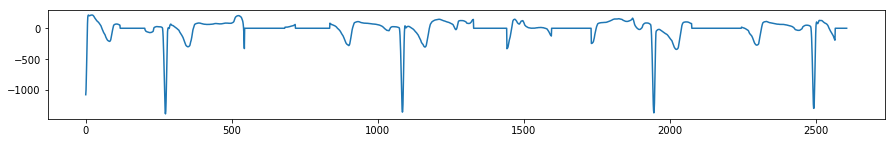

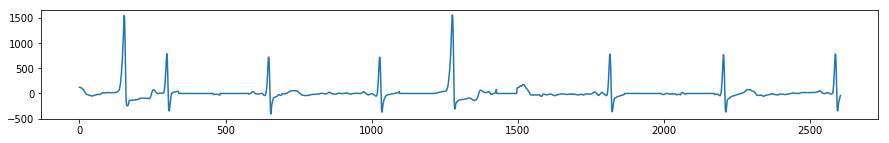

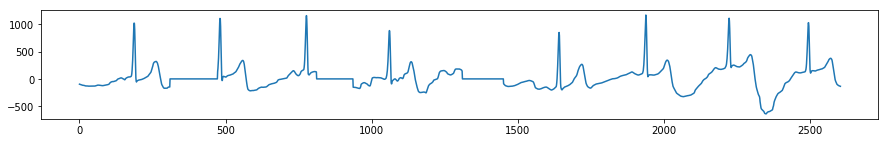

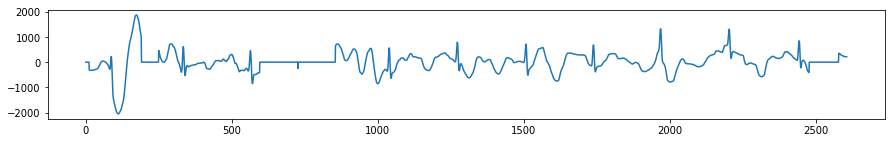

In [273]:
it = feed(X_train, Y_train, shorten=True)
print(next(it)[0].shape)
for i in range(5):
    plt.figure(figsize=(15,2))
    plt.plot(next(it)[0][0,:,0])

In [274]:
model = keras.models.Sequential()
model.add(layers.Dropout(.5, input_shape=(None, 1)))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Activation('relu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Activation('relu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Conv1D(64, 5, dilation_rate=2))
model.add(layers.Activation('relu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(layers.MaxPooling1D(2))

# model.add(layers.LSTM(256))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# class Metrics(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = model.predict(X_val).argmax(axis=1)
#         val_targ = Y_val.argmax(axis=1)
#         print("f1: %.3f" % f1_score(val_targ, val_predict, average='micro'))

model.fit_generator(feed(X_train, Y_train, shorten=True), steps_per_epoch=np.ceil(X_train.shape[0]/128), 
                    epochs=10,
                    validation_data=feed(X_val, Y_val, training=False, batch_size=1), validation_steps=X_val.shape[0])

Epoch 1/10
31/36 [========================>.....] - ETA: 2s - loss: 1.4499 - acc: 0.5502

In [ ]:
y_test = model.predict_generator(feed(X_test, None, training=False), steps=np.ceil(X_test.shape[0]/128))
assert y_test.shape[0] == X_test.shape[0]
np.savetxt("Y_test.csv", np.stack(( np.arange(X_test.shape[0]), y_test.argmax(axis=1) ), axis=1), 
           delimiter=",", header="id,y", fmt='%d', comments='')

All results after 10 epochs of training, unless otherwise stated

32 filters, no maxpooling, global avgpooling:
    acc: 0.6499 val_acc: 0.5801
64 filters, maxpooling, global avgpooling:
    acc: 0.703  val_acc: 0.4570
64 filters, maxpooling, global avgpooling, run dropout: 
    acc: 0.6844 val_acc: 0.6035; 0.433
64 filters, maxpooling, global maxpooling, run dropout: 
    acc: 0.6083 val_acc: 0.6309; 0.612
64 filters, maxpooling, LSTM, run dropout:
    acc: 0.5908 val_acc: 0.4883; 0.596
64 filters, maxpooling, global maxpooling, run dropout, shortened sequences:
    acc: 0.6725 val_acc: 0.6230
